## Black-box optimization with a generic GP agent

In this example, we will show how to setup a "textbook" black-box optimization problem of finding extrema of an unknown function, as a campaign within the CAMD framework, and solve the problem with an off-the-shelf Gaussian Process based agent with an upper-confidence-bound approach for exploration/exploitation tradeoff.

We will follow this outline:

1. Define a sample function to generate synthetic data
2. Define data, agent, experiment and analyzer of our campaign
3. Intiailize the campaign with a random seed
4. Run several iterations and keep track of the progress of the agent. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from camd.agent.generic import GenericGPUCB
from camd.analysis import GenericMaxAnalyze
from camd.experiment.base import ATFSampler
from camd.campaigns.base import Campaign

from sklearn.preprocessing import OrdinalEncoder
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
warnings.filterwarnings("ignore")

def plot_state(x, y, campaign):
    """
    this is a helper function to make plots
    """
    mu,std  = campaign.agent.pipeline.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x,mu, label='agent')
    plt.fill_between(x, mu+2*std, mu-2*std, alpha=0.2)
    plt.plot(campaign.seed_data['x'], campaign.seed_data['target'], 'ko',alpha=0.7, label='acquired')
    requests = campaign.analyzer.test_df.loc[campaign.consumed_candidates[-campaign.agent.n_query:]]
    plt.plot(requests['x'],requests['target'],'rx',alpha=0.9, label='requested')
    plt.plot(x, y, label='true f(x)')
    plt.legend()
    return plt

Let's generate some synthetic data using an arbitrary function, with one column for X and one target column.

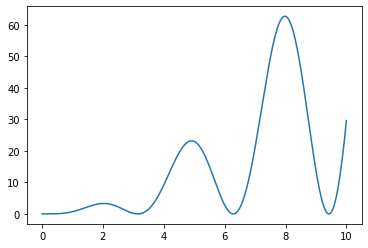

In [2]:
def f(x):
    return np.sin(x)*np.sin(x)*(x**2)
x = np.linspace(0,10,500)
y = f(x)
df = pd.DataFrame({'x': x, 'target': y})
plt.plot(x,y)

Now, say we want to maximize this "unknown" function. We will use a generic GP-UCB agent and a generic analyzer of campaigns for axquiring 'maxima' from a candidate set. Say we also want to know number of points with target value above 58.

In [3]:
N_query = 2  # This many experiments are requested in each iteration
N_seed = 5  # This many samples are randomly acquired in the beginning to form a seed.
agent = GenericGPUCB(n_query=N_query, 
                     kernel=ConstantKernel(100.0)+RBF(10.0)*ConstantKernel(1.0))
analyzer = GenericMaxAnalyze(test_df=df, threshold=58)
experiment = ATFSampler(dataframe=df)
candidate_data = df

Now we setup a campaign and initialize it. Here we instructed the Loop to generate a seed with 5 randomply selected points.

In [4]:
new_campaign = Campaign(candidate_data, agent, experiment, analyzer, create_seed=N_seed)
new_campaign.initialize(random_state=20)

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments


Let's have our agent acquire two new points and plot our results.

Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent GenericGPUCB hypothesizing
Campaign 0 state: Running experiments


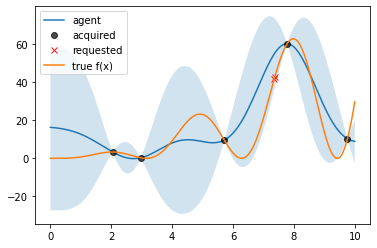

In [5]:
new_campaign.run()
plt = plot_state(x,y,new_campaign)
plt.show()

We see that the GP-UCB agent requested two new points close to maximum. Let's run the agent one more time.

Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent GenericGPUCB hypothesizing
Campaign 1 state: Running experiments


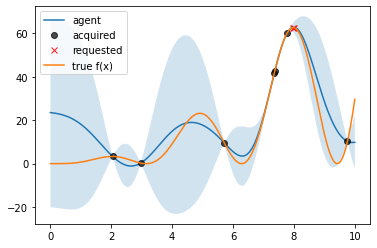

In [7]:
new_campaign.run()
plt = plot_state(x,y,new_campaign)
plt.show()

Agents confidence near the maximum of the function improved, and it acquired two highly relevant points.
Let's run again.

Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent GenericGPUCB hypothesizing
Campaign 2 state: Running experiments


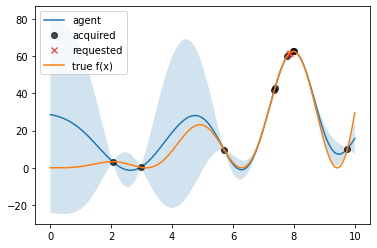

In [9]:
new_campaign.run()
plt = plot_state(x,y,new_campaign)
plt.show()

We see now another set of points close to the actual maximum are acquired. Let's run again.

Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent GenericGPUCB hypothesizing
Campaign 3 state: Running experiments


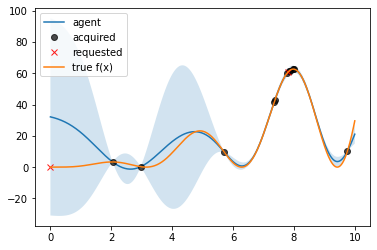

In [11]:
new_campaign.run()
plt = plot_state(x,y,new_campaign)
plt.show()

This time we observe that the agent took a `risk` and tried acquiring near where it is highly uncertain.

Campaign 4 state: Getting new results
Campaign 4 state: Analyzing results
Campaign 4 state: Agent GenericGPUCB hypothesizing
Campaign 4 state: Running experiments


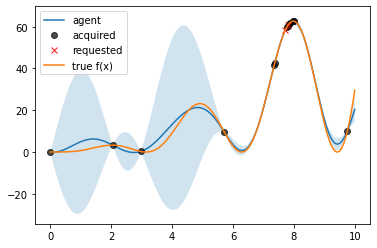

In [13]:
new_campaign.run()
plt = plot_state(x,y,new_campaign)
plt.show()

We see that now it "learned" from its mistake as its uncertainty is minimized near the previous "bad" acqusitions. The new set of acquisitions are close to ideal again.

**Conclusion**: In the context of materials science experiments, for many "low-throughput" campaigns (e.g. up to a few thousand examples) and/or low-dimensional search spaces (e.g. up to ten or twenty parameters to control), this approach is often worth trying.